In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from xml.etree import ElementTree as ET
import os
import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [4]:
def random_color():
    return [random.randint(0, 255) for _ in range(3)]

### Image Processing

In [12]:
# 分割，縮放，拼接圖片
def get_random_data(image_list, input_shape):
    
    h, w = input_shape  # resize後的尺寸
    
    # 設定拼接後的分割線位置
    min_offset_x = 0.4
    min_offset_y = 0.4  
    scale_low = 1 - min(min_offset_x, min_offset_y)  # 0.6
    scale_high = scale_low + 0.2  # 0.8
 
    image_datas = []  # images
    box_datas = []  # bounding box
    index = 0  # 第幾張圖(會放在不同位置)
    
    # 圖像分割
    for frame_list in image_list:
        
        frame = frame_list[0]  # 取出image
        box = np.array(frame_list[1:])  # 取出bounding box和label
 
        ih, iw = frame.shape[0:2]  # 原始圖片的寬高
        
        cx = (box[0,:,0] + box[0,:,2]) // 2  # bounding box中心x
        cy = (box[0,:,1] + box[0,:,3]) // 2  # bounding box中心y
 
        # 縮放圖像資訊
        new_ar = w/h  # 縮放後的寬高比
        scale = np.random.uniform(scale_low, scale_high)   # 縮放0.6-0.8倍
        # 縮放寬高
        nh = int(scale * h)  # 先縮放h維度
        nw = int(nh * new_ar)  # 依據原始寬高比例縮放w維度
        
        # resize
        frame = cv2.resize(frame, (nw,nh))
        
        # 調整中心點座標
        cx = cx * nw/iw 
        cy = cy * nh/ih 
 
        # 調整bounding box
        bw = (box[0,:,2] - box[0,:,0]) * nw/iw
        bh = (box[0,:,3] - box[0,:,1]) * nh/ih
        
        # 創建448x448的背景板
        new_frame = np.zeros((h,w,3), np.uint8)
        
        # 根據第幾張圖片放在不同位置
        if index==0: new_frame[0:nh, 0:nw] = frame   # 左上
        elif index==1: new_frame[0:nh, w-nw:w] = frame  # 右上
        elif index==2: new_frame[h-nh:h, 0:nw] = frame  # 左下
        elif index==3: new_frame[h-nh:h, w-nw:w] = frame  # 右下
 
        # 修正bounding box的位置
        if index==0:  # 左上
            box[0,:,0] = cx - bw // 2  # x1
            box[0,:,1] = cy - bh // 2  # y1
            box[0,:,2] = cx + bw // 2  # x2
            box[0,:,3] = cy + bh // 2  # y2         
        
        if index==1:  # 右上
            box[0,:,0] = cx - bw // 2 + w - nw  # x1
            box[0,:,1] = cy - bh // 2  # y1
            box[0,:,2] = cx + bw // 2 + w - nw # x2
            box[0,:,3] = cy + bh // 2  # y2
        
        if index==2:  # 左下
            box[0,:,0] = cx - bw // 2  # x1
            box[0,:,1] = cy - bh // 2 + h - nh  # y1
            box[0,:,2] = cx + bw // 2  # x2
            box[0,:,3] = cy + bh // 2 + h - nh  # y2
 
        if index==3:  # 右下
            box[0,:,0] = cx - bw // 2 + w - nw # x1
            box[0,:,1] = cy - bh // 2 + h - nh # y1
            box[0,:,2] = cx + bw // 2 + w - nw # x2
            box[0,:,3] = cy + bh // 2 + h - nh  # y2
    
        index = index + 1  # 下一張圖片
        
        # 保存處理後的image和bounding box資訊
        image_datas.append(new_frame)
        box_datas.append(box)
    
    # 檢查處理後的image和bounding box
    # for image, boxes in zip(image_datas, box_datas):
        
    #     # 複製原圖
    #     image_copy = image.copy()
        
    #     # 繪製bounding box
    #     for box in boxes[0]:  
    #         x1, y1, x2, y2, label = box
    #         color = random_color()
    #         cv2.rectangle(image_copy, (x1,y1), (x2,y2), color, 2, cv2.LINE_AA)
    #         t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
    #         c1 = int(x1), int(y1)
    #         c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    #         cv2.rectangle(image_copy, c1, c2, color, -1, cv2.LINE_AA)
    #         cv2.putText(image_copy, classes_name[int(label)], (int(x1), int(y1)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    #     plt.imshow(image_copy)
    #     plt.axis('off')
    #     plt.show()

    # 把四張圖拼接在一起
    # 在指定範圍中選擇橫縱向分割線
    cutx = np.random.randint(int(w*min_offset_x), int(w*(1-min_offset_x)))
    cuty = np.random.randint(int(h*min_offset_y), int(h*(1-min_offset_y)))        
    
    # 創建448x448的背景板用於拼接四張圖片
    new_image = np.zeros((h,w,3), np.uint8)
    new_image[:cuty, :cutx, :] = image_datas[0][:cuty, :cutx, :]
    new_image[:cuty, cutx:, :] = image_datas[1][:cuty, cutx:, :]
    new_image[cuty:, :cutx, :] = image_datas[2][cuty:, :cutx, :]
    new_image[cuty:, cutx:, :] = image_datas[3][cuty:, cutx:, :]
    
    # 顯示拼接後的圖片
    # plt.imshow(new_image)
    # plt.axis('off')
    # plt.show()

    # 複製拼接後圖片
    final_image_copy = new_image.copy()
    
    # 顯示拼接後的所有bounding box
    # for boxes in box_datas:
    #     for box in boxes[0]:  
    #         x1, y1, x2, y2, label = box
    #         color = random_color()
    #         cv2.rectangle(final_image_copy, (x1,y1), (x2,y2), color, 2, cv2.LINE_AA)
    #         t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
    #         c1 = int(x1), int(y1)
    #         c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    #         cv2.rectangle(final_image_copy, c1, c2, color, -1, cv2.LINE_AA)
    #         cv2.putText(final_image_copy, classes_name[int(label)], (int(x1), int(y1)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    # plt.imshow(final_image_copy)
    # plt.axis('off')
    # plt.show()

    # 處理超過分割線的bounding boxes
    new_boxes = merge_bboxes(box_datas, cutx, cuty)
    
    # 複製合併後圖像
    modify_image_copy = new_image.copy()
    
    # 繪製修正後的bounding boxes
    produced_data = ""
    for boxes in new_boxes:
        for box in boxes:
            x1, y1, x2, y2, label = box
            # color = random_color()
            # cv2.rectangle(modify_image_copy, (x1,y1), (x2,y2), color, 2, cv2.LINE_AA)
            # t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
            # c1 = int(x1), int(y1)
            # c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
            # cv2.rectangle(modify_image_copy, c1, c2, color, -1, cv2.LINE_AA)
            # cv2.putText(modify_image_copy, classes_name[int(label)], (int(x1), int(y1)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
            produced_data += f" {x1} {y1} {x2} {y2} {label}"
    # plt.imshow(modify_image_copy)
    # plt.axis('off')
    # plt.show()
    return new_image, produced_data


# 處理超過分割線的bounding boxes
def merge_bboxes(bboxes, cutx, cuty):
    
    # 修改後的bounding box
    merge_box = []
    
    for i, box in enumerate(bboxes):
        
        # 每張image需要刪掉的boudning box
        index_list = []
        
        # 遍歷所有bounding box,index代表第幾個
        for index, box in enumerate(box[0]):     

            x1, y1, x2, y2, label = box
            
            # 左上圖，修改右側及下側的分割線
            if i== 0:
                # 如果bounding box的左上座標不在分割線內就刪除
                if x1 > cutx or y1 > cuty:
                    index_list.append(index) 
    
                # 如果bounding box的右下座標不在分割線內，取分割線邊界為新右下座標
                if y2 >= cuty and y1 <= cuty:
                    y2 = cuty
                    # 修正後bounding box高度過矮則也刪除
                    if y2-y1 < 10:
                        index_list.append(index)
                
                if x2 >= cutx and x1 <= cutx:
                    x2 = cutx
                    # 修正後bounding box寬度過窄則也刪除
                    if x2-x1 < 10:
                        index_list.append(index) 
            
            # 右上圖，修改左側及下側的分割線
            if i == 1:
                if x2 < cutx or y1 > cuty:
                    index_list.append(index) 
                
                if y2 >= cuty and y1 <= cuty:
                    y2 = cuty
                    if y2-y1 < 10:
                        index_list.append(index)
                
                if x1 <= cutx and x2 >= cutx:
                    x1 = cutx
                    if x2-x1 < 10:
                        index_list.append(index) 
            
            # 左下圖，修改右側及上側的分割線
            if i == 2:
                if x1 > cutx or y2 < cuty:
                    index_list.append(index) 
                
                if y1 <= cuty and y2 >= cuty:
                    y1 = cuty
                    if y2-y1 < 10:
                        index_list.append(index) 
                
                if x1 <= cutx and x2 >= cutx:
                    x2 = cutx
                    if x2-x1 < 10:
                        index_list.append(index) 
            
            # 右下圖，修改左側及上側的分割線
            if i == 3:
                if x2 < cutx or y2 < cuty:
                    index_list.append(index) 
                
                if x1 <= cutx and x2 >= cutx:
                    x1 = cutx
                    if x2-x1 < 10:
                        index_list.append(index) 
                
                if y1 <= cuty and y2 >= cuty:
                    y1 = cuty
                    if y2-y1 < 10:
                        index_list.append(index) 
                   
            # 更新bounding box資訊
            bboxes[i][0][index] = [x1, y1, x2, y2, label] 
       
        # 刪除超出分割線的bounding box
        merge_box.append(np.delete(bboxes[i][0], index_list, axis=0))
 
    return merge_box


### Test mosaic (this cell can be ignored)

In [13]:
images_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/JPEGImages/')
annotations_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/Annotations/')

image_dir = './datasets/VOCdevkit_train/VOC2007/JPEGImages/'
annotation_dir = './datasets/VOCdevkit_train/VOC2007/Annotations/'

# training_data_file = open("./datasets/pascal_voc_training_data.txt", "r")

image_list = []  # 存放image和bounding box訊息

random_pick = np.random.randint(low=0, high=5011, size=4)

for i in random_pick:

    image_boxes = []  # bounding box
    # object_classes = []  # object classes

    # image_path = image_dir + str(i+1) + '.jpg'
    # annotation_path = annotation_dir + str(i+1) + '.xml'
    print(images_name[i])
    print(annotations_name[i])
    image_path = image_dir + images_name[i]
    annotation_path = annotation_dir + annotations_name[i]

    image = cv2.imread(image_path)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 使用library讀取bounding box
    with open(annotation_path, 'r') as new_f:
        #  getroot()取得root
        root = ET.parse(annotation_path).getroot()
    
    # findall找物件，find找各物件內的資訊
    for obj in root.findall('object'):
        obj_name = obj.find('name').text   # object name
        object_class = classes_name.index(obj_name)
        bndbox = obj.find('bndbox')
        left = eval(bndbox.find('xmin').text)    
        top = eval(bndbox.find('ymin').text)     
        right = eval(bndbox.find('xmax').text)   
        bottom = eval(bndbox.find('ymax').text)  
 
        image_boxes.append([left, top, right, bottom, object_class])  # [[x1,y1,x2,y2,label],[..],[..]]
        # object_classes.append(object_class)

    # 保存image和對應bounding box
    image_list.append([image, image_boxes])
    # produced_data.append(images_name[i])
    


# 分割，縮放，拼接圖片，指定尺寸448x448
new_image, new_data = get_random_data(image_list, input_shape=[448,448])

003511.jpg
003511.xml
005348.jpg
005348.xml
006704.jpg
006704.xml
003651.jpg
003651.xml


 29 8 209 203 1 307 90 443 203 14 209 14 337 203 14 20 203 202 318 19 215 203 447 447 18 366 232 392 306 14


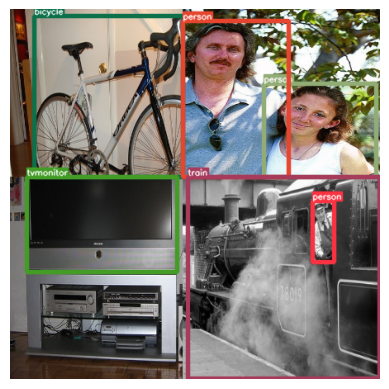

In [14]:
# check result whether is correct
print(new_data)
check_data = new_data.split()
objs = [check_data[i:i + 5] for i in range(0, len(check_data), 5)]
for x, y, x_, y_, label in objs:
    # print(x, y, x_, y_, label)
    color = random_color()
    cv2.rectangle(new_image, (int(x), int(y)), (int(x_) ,int(y_)), color, 3, cv2.LINE_AA)
    t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=1 / 3, thickness=1)[0]
    c1 = int(x), int(y)
    c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
    cv2.rectangle(new_image, c1, c2, color, -1, cv2.LINE_AA)
    cv2.putText(new_image, classes_name[int(label)], (int(x), int(y)-2), 0, 1 / 3, (255, 255, 255), thickness=1, lineType=cv2.LINE_AA)

plt.imshow(new_image)
plt.axis('off')
plt.show()

### Produced data

In [17]:
images_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/JPEGImages/')
annotations_name = os.listdir('./datasets/VOCdevkit_train/VOC2007/Annotations/')

image_dir = './datasets/VOCdevkit_train/VOC2007/JPEGImages/'
annotation_dir = './datasets/VOCdevkit_train/VOC2007/Annotations/'

now_image_index = 101000

for num in range(1000):
    image_list = []  # 存放image和bounding box訊息

    random_pick = np.random.randint(low=0, high=5011, size=4)

    for i in random_pick:

        image_boxes = []  # bounding box
        # object_classes = []  # object classes

        # image_path = image_dir + str(i+1) + '.jpg'
        # annotation_path = annotation_dir + str(i+1) + '.xml'
        # print(images_name[i])
        # print(annotations_name[i])
        image_path = image_dir + images_name[i]
        annotation_path = annotation_dir + annotations_name[i]

        image = cv2.imread(image_path)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 使用library讀取bounding box
        with open(annotation_path, 'r') as new_f:
            #  getroot()取得root
            root = ET.parse(annotation_path).getroot()
        
        # findall找物件，find找各物件內的資訊
        for obj in root.findall('object'):
            obj_name = obj.find('name').text   # object name
            object_class = classes_name.index(obj_name)
            bndbox = obj.find('bndbox')
            left = eval(bndbox.find('xmin').text)    
            top = eval(bndbox.find('ymin').text)     
            right = eval(bndbox.find('xmax').text)   
            bottom = eval(bndbox.find('ymax').text)  
        
            image_boxes.append([left, top, right, bottom, object_class])  # [[x1,y1,x2,y2,label],[..],[..]]
            # object_classes.append(object_class)

        # 保存image和對應bounding box
        image_list.append([image, image_boxes])
        # produced_data.append(images_name[i])


    # 分割，縮放，拼接圖片，指定尺寸448x448
    new_image, new_data = get_random_data(image_list, input_shape=[448,448])

    # 儲存圖片和bounding box資訊
    with open("./datasets/pascal_voc_training_data.txt", "a") as file:
        new_image_name = f"{now_image_index + num + 1}.jpg"
        new_rgb_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(image_dir + new_image_name, new_rgb_image)
        new_data = new_data.strip()
        file.write(new_image_name + f" {new_data}" + '\n')

### Check Produced Data

100997.jpg 0 19 192 185 18 247 0 446 185 5 263 93 349 153 14 247 98 257 154 14 193 185 247 439 14 136 185 216 403 14 6 185 134 390 14 111 185 129 257 14 247 185 395 447 14


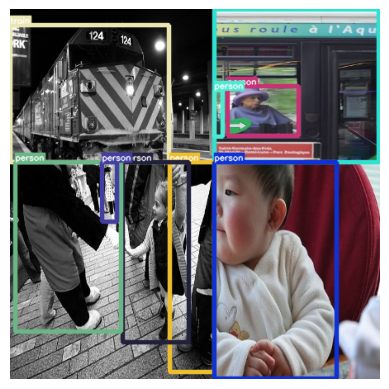

100998.jpg 133 137 190 181 17 39 59 190 181 14 190 34 262 158 14 190 43 306 181 17 277 94 447 164 17 190 151 387 181 11 174 197 190 417 3 50 211 70 417 3 126 382 160 394 3 89 343 111 395 3 21 309 51 397 3 250 309 322 363 1 245 271 305 363 14


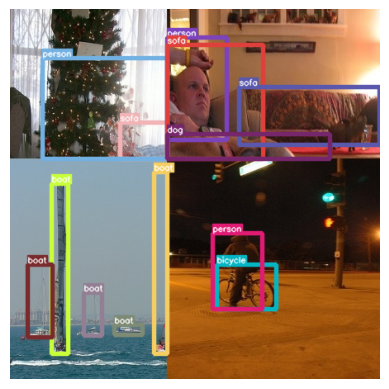

100999.jpg 154 159 218 195 18 250 8 368 246 14 222 166 259 246 7 83 265 222 447 9 89 246 149 438 14 0 246 26 350 1 152 246 222 434 13 397 311 447 407 8 369 305 393 325 8 437 301 447 335 8 397 302 419 358 8 222 246 447 447 14 364 284 378 304 14 383 287 393 303 14 352 284 362 302 14 357 320 403 376 10


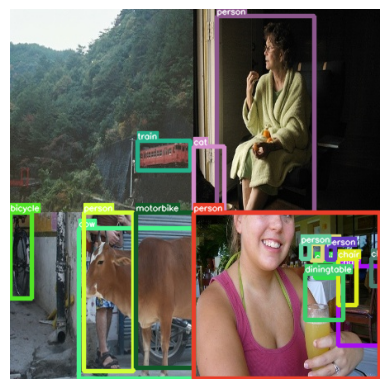

101000.jpg 93 48 238 194 1 238 158 258 194 19 117 251 233 381 12 238 195 251 217 15 256 221 286 249 15 238 232 258 290 15 252 243 310 347 15 301 195 361 323 15 352 251 422 395 15 421 275 447 383 15 417 194 443 244 15 415 242 447 292 15


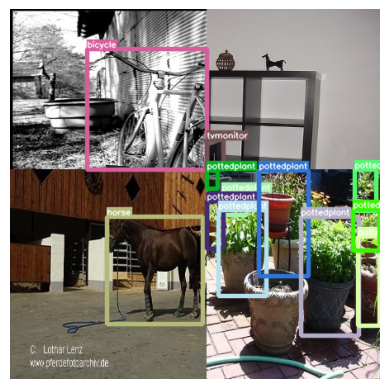

In [18]:
tl = 1
tk = 1

with open("./datasets/pascal_voc_training_data.txt", "r") as file:
    lines = file.readlines()

testLine = lines[-4:]

for i, line in enumerate(testLine):
    line = line.strip()
    print(line)
    line = line.split()
    img_name = line[0]
    img = cv2.imread(f'./datasets/VOCdevkit_train/VOC2007/JPEGImages/{img_name}')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    objs = [line[i:i + 5] for i in range(1, len(line), 5)]
    for x, y, x_, y_, label in objs:
        color = random_color()
        cv2.rectangle(img, (int(x), int(y)), (int(x_) ,int(y_)), color, 3, cv2.LINE_AA)
        t_size = cv2.getTextSize(classes_name[int(label)], 0, fontScale=tl / 3, thickness=tk)[0]
        c1 = int(x), int(y)
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)
        cv2.putText(img, classes_name[int(label)], (int(x), int(y)-2), 0, tl / 3, (255, 255, 255), thickness=tk, lineType=cv2.LINE_AA)

    plt.imshow(img)
    plt.axis('off')
    plt.show()